Link to the competition: https://tianchi.aliyun.com/competition/entrance/231705/introduction

In [2]:
import sys
import pickle
import warnings
import spacy
import time
from spacy.lang.en.stop_words import STOP_WORDS
import numpy as np
import pandas as pd 
import json
import seaborn as sns
from bs4 import BeautifulSoup
import urllib.parse
from urllib.request import urlopen, Request
from urllib.error import HTTPError
from keras import optimizers
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models import LdaModel, TfidfModel
import pyLDAvis.gensim as gensimvis
import pyLDAvis
from spacy.tokens import Token
from spacy.lang.en.stop_words import STOP_WORDS  # import stop words from language data
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from utils.plot_functions import *
%matplotlib inline
nlp = spacy.load("en_core_web_sm")
pd.set_option('display.max_colwidth', 500)
%load_ext autoreload
%autoreload 2
if not sys.warnoptions:
    warnings.simplefilter("ignore")

Using TensorFlow backend.


In [3]:
def extract_tweet_id(link):
    try:
        return int(link.split('/')[-1])
    except:
        return -1

In [40]:
def get_url(text):
    try:
        url =  text.split(' ')[-1]
        if 'https://' in url or 'http://' in url:
            return url
    except:
        return None

# Load Raw Data

In [41]:
df_train = pd.read_table('./data/[Updated] Training Set for Competition.txt',sep='\t')

In [42]:
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%d.%m.%Y').dt.date
df_train['Event ID'] = df_train['Event ID'].fillna(0)
df_train['Is_Food'] = df_train['Event ID'] > 0
df_train['tweet_id'] = df_train['Link'].apply(extract_tweet_id)
df_train['external_url'] = df_train['Abstract'].apply(get_url)

In [43]:
df_train.head(3)

,Date,Time,Trainig/Test,Event ID,Title,Link,Abstract,Is_Food,tweet_id,external_url
0,2019-02-05,18:45:44,Training,1.0,New dog food recall and latest warning on grain-free foods #SmartNews,https://twitter.com/tweet/status/1092857075753861125,New dog food recall and latest warning on grain-free foods #SmartNews https://t.co/nS49e7r63l,True,1092857075753861125,https://t.co/nS49e7r63l
1,2019-02-05,06:29:38,Training,1.0,New Dog Food Recall And The Latest Warning On Grain-Free Foods... https://t.co/brx3qW4t4L,https://twitter.com/tweet/status/1092671572400373760,New Dog Food Recall And The Latest Warning On Grain-Free Foods... https://t.co/brx3qW4t4L https://t.co/5XcIAt9g4p,True,1092671572400373760,https://t.co/5XcIAt9g4p
2,2019-02-05,18:40:20,Training,1.0,RT @BaybeeReade: Another dog food recall over dangerous levels of vitamin D - Fox News,https://twitter.com/tweet/status/1092855599233150977,RT @BaybeeReade: Another dog food recall over dangerous levels of vitamin D - Fox News https://t.co/z0w17ubVay,True,1092855599233150977,https://t.co/z0w17ubVay


In [45]:
df_test = pd.read_table('./data/[Updated] Test Set for Competition.txt',sep='\t')
df_test['tweet_id'] = df_test['Link'].apply(extract_tweet_id)
df_test['external_url'] = df_test['Abstract'].apply(get_url)

In [46]:
df_test.head(3)

,Date,Time,Training/Test,Title,Link,Abstract,tweet_id,external_url
0,2019-03-07,23:59:31,Test,@pccs_heron Salmonella,https://twitter.com/tweet/status/1103807421800202242,@pccs_heron Salmonella,1103807421800202242,None
1,2019-03-07,23:59:20,Test,@richardlanigan @trishgreenhalgh No. It's not feaces alone. Not at all. Polio virus is transmitted by the feacal…,https://twitter.com/tweet/status/1103807373196623873,@richardlanigan @trishgreenhalgh No. It's not feaces alone. Not at all. Polio virus is transmitted by the feacal… https://t.co/8ziThZHccA,1103807373196623873,https://t.co/8ziThZHccA
2,2019-03-07,23:59:02,Test,@PatchouliW @BecciCath @MavenOfMayhem @SwiftOnSecurity For a while I thought I was allergic to water because of the…,https://twitter.com/tweet/status/1103807299389349889,@PatchouliW @BecciCath @MavenOfMayhem @SwiftOnSecurity For a while I thought I was allergic to water because of the… https://t.co/XoMGCuQLcs,1103807299389349889,https://t.co/XoMGCuQLcs


# Web Scraping

## Web Scrapping on external link title

In [10]:
def get_title(url):
    try:
        r = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
        html = urlopen(r)
    except:
        return(None)
    try:
         title = BeautifulSoup(html.read()).title.text
    except:
        return(None)
    return(title)

In [43]:
df_test['external_url'] = df_test['Abstract'].apply(get_url)

In [ ]:
%%time
temp = []
for url in log_progress(df_test['external_url'], every = 1):
    temp.append(get_title(url))
df_test['external_url_title'] = temp

In [142]:
external_title_columns = ['external_url','external_url_title']

In [145]:
df_test.drop_duplicates(subset = 'external_url')[external_title_columns].to_csv('./processed_data/test_external_title.csv', index = False)

## Web Scraping on Tweet Data

In [ ]:
!pip install Twython

In [48]:
from twython import Twython
with open('api_key.txt','r') as inf:
    key_dict = eval(inf.read())

In [49]:
CONSUMER_KEY = key_dict['CONSUMER_KEY']
CONSUMER_SECRET = key_dict['CONSUMER_SECRET']
OAUTH_TOKEN = key_dict['OAUTH_TOKEN']
OAUTH_TOKEN_SECRET = key_dict['OAUTH_TOKEN_SECRET']
twitter = Twython(
    CONSUMER_KEY, CONSUMER_SECRET,
    OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

In [103]:
def add_more_info(tweet_id):
    r = {
        'tweet_found':True,
        'user_name':'',
        'mentions':[],
        'medias':None,
        'hashtags':[],
        'in_reply_to_status_id':None,
        'in_reply_to_screen_name':None,
        'in_reply_to_status_text':None
    }
    
    if tweet_id == -1:
        return r
    
    flag = True
    while(flag):
        try:
            tweet = twitter.show_status(id=tweet_id)
            flag = False

        except Exception as e:
            if e.msg != 'Twitter API returned a 429 (Too Many Requests), Rate limit exceeded':
                r['tweet_found'] = False
                flag = False
                return r
            else:
                print(e.msg)
                print('Sleeping for a min ......')
                time.sleep(60)
                
    r['user_name'] = tweet['user']['name']
    r['mentions'] = [v for mention in tweet['entities']['user_mentions'] for k,v in mention.items() if k == 'screen_name'] 
    try:
        r['medias'] = [v for media in tweet['entities']['media'] for k,v in media.items() if k == 'media_url']
    except:
        pass
    r['hashtags'] = [v for mention in tweet['entities']['hashtags'] for k,v in mention.items() if k == 'text']
    r['in_reply_to_status_id'] = tweet['in_reply_to_status_id']
    r['in_reply_to_screen_name'] = tweet['in_reply_to_screen_name']
    if r['in_reply_to_status_id'] is not None:
        try:
            main_tweet = twitter.show_status(id=r['in_reply_to_status_id'])
            r['in_reply_to_status_text'] = main_tweet['text']
        except:
            pass
    
    return r

Train

In [ ]:
extra_infos = []
for tweet_id in log_progress(df_train['tweet_id'][3400:] , every = 1):
    extra_infos.append(add_more_info(tweet_id))

In [110]:
df_train_merge = pd.concat([df_train, pd.DataFrame(extra_infos)], axis = 1)

Test

In [ ]:
extra_infos = []
for tweet_id in log_progress(df_test['tweet_id'] , every = 1):
    extra_infos.append(add_more_info(tweet_id))

In [115]:
df_extra_infos = pd.DataFrame(extra_infos)
df_test_merge = pd.concat([df_test, df_extra_infos], axis = 1)

In [15]:
tweet_api_columns =  [
    'Link', 
    'tweet_found',
    'user_name',
    'mentions',
    'medias',
    'hashtags',
    'in_reply_to_status_id',
    'in_reply_to_screen_name',
    'in_reply_to_status_text'
]

In [16]:
df_train_merge.drop_duplicates(subset = 'Link')[tweet_api_columns].to_csv('./processed_data/train_external_tweet.csv', index = False)
df_test_merge.drop_duplicates(subset = 'Link')[tweet_api_columns].to_csv('./processed_data/test_external_tweet.csv', index = False)

## Merge Back

In [47]:
train_external_tweet = pd.read_csv('./processed_data/train_external_tweet.csv')
test_external_tweet = pd.read_csv('./processed_data/test_external_tweet.csv')
test_external_title = pd.read_csv('./processed_data/test_external_title.csv')

In [53]:
df_train_merge = df_train.merge(train_external_tweet, on = 'Link', how = 'left')

In [54]:
df_test_merge = df_test.merge(test_external_tweet, on = 'Link', how = 'left')\
                       .merge(test_external_title, on = 'external_url', how = 'left')

# NLP on Abstract

## Pre-process

- Use title instead of abstract to mitigate noise
- Replace title text with in_reply_to_status_text
- Replace title text with external_url_title

In [55]:
df_train_merge['New_Title'] = df_train_merge['Title']
subset = df_train_merge['in_reply_to_status_text'].notnull()
df_train_merge.loc[subset, 'New_Title'] = df_train_merge[subset]['in_reply_to_status_text']

In [56]:
df_test_merge['New_Title'] = df_test_merge['Title']
subset = df_test_merge['in_reply_to_status_text'].notnull()
subset2 = df_test_merge['in_reply_to_status_text'].isnull() & df_test_merge['external_url_title'].notnull()
df_test_merge.loc[subset, 'New_Title'] = df_test_merge[subset]['in_reply_to_status_text']
df_test_merge.loc[subset2, 'New_Title'] = df_test_merge[subset2]['external_url_title']

## Remove stop words, and tokenize

In [59]:
stop_words_getter = lambda token: token.is_stop or token.lemma_ in STOP_WORDS
Token.set_extension('is_stop', getter=stop_words_getter, force=True)  # set attribute with getter

In [60]:
def filter_token(token):
    if(token.is_punct or \
       token.is_digit or \
       token.is_space or \
       token.like_num or \
       not token.text.isalpha() or \
       token.lemma_ == '-PRON-' or \
       'http' in token.text or \
       '@' in token.text or \
       '#' in token.text or \
       "’s" in token.text or \
       "'s" in token.text or \
       token.text == 'rt' or \
       len(token.text) <= 1 or \
       token._.is_stop):
        return(False)
    else:
        return(True)

In [61]:
def clean(text):
    return [token.lemma_ for token in nlp(str(text).lower()) if filter_token(token)]

In [62]:
def get_num(text):
    return [token.text for token in nlp(str(text).lower()) if token.like_num]

In [63]:
def clean_sentence(sentence):
    output = []
    for w in sentence.split(' '):
        if 'http' in w or \
           '@' in w or \
           '#' in w or \
           'RT' in w:
            pass
        else:
            output.append(w)
    return ' '.join(output)

### Train

In [65]:
%%time
temp = []
for text in log_progress(df_train_merge['New_Title'], every = 100):
    temp.append(clean(text))
df_train_merge['ab_clean'] = temp

CPU times: user 3min 7s, sys: 28.4 s, total: 3min 35s
Wall time: 36.7 s


In [66]:
df_train_merge[['New_Title','ab_clean']].head(3)

,New_Title,ab_clean
0,New dog food recall and latest warning on grain-free foods #SmartNews,"[new, dog, food, recall, late, warning, grain, free, food, smartnew]"
1,New Dog Food Recall And The Latest Warning On Grain-Free Foods... https://t.co/brx3qW4t4L,"[new, dog, food, recall, late, warning, grain, free, food]"
2,RT @BaybeeReade: Another dog food recall over dangerous levels of vitamin D - Fox News,"[dog, food, recall, dangerous, level, vitamin, fox, news]"


### Test

In [67]:
%%time
temp = []
for text in log_progress(df_test_merge['New_Title'], every = 100):
    temp.append(clean(text))
df_test_merge['ab_clean'] = temp

CPU times: user 18min 54s, sys: 2min 41s, total: 21min 36s
Wall time: 3min 39s


In [70]:
df_test_merge[['New_Title','ab_clean']].head(3)

,New_Title,ab_clean
0,My fourth and fifth grade class is studying microbes and wants to run a March Microbe Madness (Fungi/Algae/Virus/Ba… https://t.co/nFhdS2Edjq,"[fourth, fifth, grade, class, study, microbe, want, run, march, microbe, madness, fungus, algae, virus, ba]"
1,@Doctorshaib @trishgreenhalgh But you have to come in contact with the faces of the infected person to catch polio.… https://t.co/2ZSz8RqCgU,"[come, contact, face, infected, person, catch, polio]"
2,@PatchouliW @BecciCath @MavenOfMayhem @SwiftOnSecurity Going gluten free was a total walk in the park compared to c… https://t.co/n8SRWjlv92,"[gluten, free, total, walk, park, compare]"


## Extract Numbers

In [68]:
%%time
temp = []
for text in log_progress(df_train_merge['New_Title'], every = 100):
    temp.append(get_num(text))
df_train_merge['numbers'] = temp

CPU times: user 2min 54s, sys: 24.4 s, total: 3min 18s
Wall time: 33.7 s


In [69]:
%%time
temp = []
for text in log_progress(df_test_merge['New_Title'], every = 100):
    temp.append(get_num(text))
df_test_merge['numbers'] = temp

CPU times: user 18min 7s, sys: 2min 31s, total: 20min 38s
Wall time: 3min 29s


## Remove Garbage words from 宝石


In [74]:
import pickle
fr = open('./data/garbage.txt', 'rb')
garbage = pickle.load(fr)
fr.close()

In [75]:
garbage = set([t[0] for t in garbage])

In [76]:
def remove_garbage(x):
    return [xx for xx in x if xx not in garbage]

In [77]:
df_train_merge['ab_clean'] = df_train_merge['ab_clean'].apply(remove_garbage)
df_test_merge['ab_clean'] = df_test_merge['ab_clean'].apply(remove_garbage)

## Highlight zero length abstract

In [79]:
df_train_merge['zero_length'] = df_train_merge['ab_clean'].apply(lambda x: True if len(x) == 0 or x == ['nan'] else False)
df_test_merge['zero_length'] = df_test_merge['ab_clean'].apply(lambda x: True if len(x) == 0 or x == ['nan'] else False)

In [80]:
print(sum(df_train_merge['zero_length']), 'zero length cleaned abstract in training set.')
print(sum(df_test_merge['zero_length']), 'zero length cleaned abstract in test set.')

8 zero length cleaned abstract in training set.
1684 zero length cleaned abstract in test set.


# Create features for binary classification

In [81]:
features = set()

## Bacteria Names

In [82]:
#http://www.bacterio.net/-alintro.html
f = open('./data/bacteria.txt')
bacterias = []
for line in f:
    if ' ' in line:
        bacterias.append(line.lower().split(' ')[1])
bacterias = set(bacterias)

In [83]:
def has_bacteria(words, bacterias):
    output = []
    for word in words:
        if word in bacterias:
            output.append(word)
    return output

In [84]:
%%time
df_train_merge['bacteria'] = df_train_merge['ab_clean'].apply(lambda x: has_bacteria(x, bacterias))

CPU times: user 4.65 ms, sys: 58 µs, total: 4.71 ms
Wall time: 4.68 ms


In [85]:
y_1_bac = [xx for x in df_train_merge[df_train_merge['Event ID'] >= 1]['bacteria'] for xx in x if x ]
y_0_bac = [xx for x in df_train_merge[df_train_merge['Event ID'] == 0]['bacteria'] for xx in x if x ]

In [86]:
pd.Series(y_0_bac).value_counts().head(15)

salmonella       531
listeria          49
bacteria          12
list              11
type              11
bacillus           6
article            3
campylobacter      3
support            3
escherichia        2
strain             2
information        2
legal              1
mycobacterium      1
für                1
dtype: int64

In [87]:
pd.Series(y_1_bac).value_counts().head(15)

salmonella     1402
listeria        790
bacteria         10
type              6
information       5
list              4
dtype: int64

***Feature***
- None

## NLP Features

### Verbs

In [88]:
def get_verb(text):
    try:
        doc = nlp(text)
        output = []
        for token in doc:
            if token.pos_ in ['VERB']:
                output.append(token.lemma_)
        return output
    except:
        return []

In [89]:
%%time
df_train_merge['verbs'] = df_train_merge['New_Title'].apply(clean_sentence).apply(get_verb)

CPU times: user 2min 34s, sys: 21.4 s, total: 2min 55s
Wall time: 29.8 s


In [90]:
y_1_verbs = [xx for x in df_train_merge[df_train_merge['Event ID'] >= 1]['verbs'] for xx in x if x ]
y_0_verbs = [xx for x in df_train_merge[df_train_merge['Event ID'] == 0]['verbs'] for xx in x if x ]

In [91]:
pd.Series(y_0_verbs).value_counts().head(15)

be        500
get       186
eat       165
have      144
do        128
can        83
recall     45
will       45
go         42
make       38
link       37
think      34
would      34
know       33
’          33
dtype: int64

In [92]:
pd.Series(y_1_verbs).value_counts().head(30)

recall         1848
be              603
sell            353
have            256
may             120
announce        104
contain          82
issue            75
check            60
fear             56
contaminate      53
can              46
find             44
prompt           40
say              33
could            26
eat              25
do               22
get              19
discover         18
read             17
blame            16
include          15
affect           13
remind           13
share            12
hit              12
avoid            12
wrap             12
make             11
dtype: int64

***Features***
- None

### Noun

In [93]:
def get_noun_chunk(text):
    try:
        doc = nlp(text)
        output = []
        for chunk in doc.noun_chunks:
            output.append(chunk.root.text)
        return output
    except:
        return []

In [94]:
%%time
df_train_merge['nouns'] = df_train_merge['New_Title'].apply(clean_sentence).apply(get_noun_chunk)
df_test_merge['nouns'] = df_test_merge['New_Title'].apply(clean_sentence).apply(get_noun_chunk)

CPU times: user 19min 33s, sys: 2min 53s, total: 22min 27s
Wall time: 3min 49s


In [95]:
y_1_nouns = [xx for x in df_train_merge[df_train_merge['Event ID'] >= 1]['nouns'] for xx in x if x ]
y_0_nouns = [xx for x in df_train_merge[df_train_merge['Event ID'] == 0]['nouns'] for xx in x if x ]

In [96]:
pd.Series(y_0_nouns).value_counts().head(30)

salmonella       309
I                204
you              150
it               122
dough            106
i                 94
food              67
chicken           65
me                64
side              49
outbreaks         48
Salmonella        47
eggs              43
we                42
salmon            37
outbreak          35
hedgehogs         34
CDC               33
What              29
Outbreak          28
people            27
recall            25
Hedgehogs         25
they              24
coli              23
You               22
who               21
contamination     21
anyone            20
hands             20
dtype: int64

In [97]:
pd.Series(y_1_nouns).value_counts().head(30)

Mills            983
flour            776
concerns         534
bags             504
Flour            500
nectarines       496
plums            351
contamination    288
recall           279
Peaches          277
Listeria         268
Walmart          249
fears            232
Salmonella       209
peaches          170
food             153
Costco           153
stores           146
Recall           120
Foods            119
salmonella       113
Bags             110
nuggets          106
RECALL           104
Fears            102
listeria         100
Aldi              99
Concerns          98
Fruit             93
Nectarines        78
dtype: int64

***Features***

In [98]:
bad_nouns = ['I', 'you', 'i', 'me', 'we', 'they', 'It', 'You']

In [99]:
for temp in [df_train_merge, df_test_merge]:
    for col in bad_nouns:
        temp['neg_noun_' + col] = temp['nouns'].apply(lambda x: col in x)
        features.add('neg_noun_' + col)

### NNP

In [100]:
def get_nnp(text):
    count = 0
    try:
        doc = nlp(text)
        for token in doc:
            if token.tag_ in ['NNP']:
                count +=1
        return count
    except:
        return count

In [101]:
%%time
df_train_merge['nnp'] = df_train_merge['New_Title'].apply(clean_sentence).apply(get_nnp)
df_test_merge['nnp'] = df_test_merge['New_Title'].apply(clean_sentence).apply(get_nnp)

CPU times: user 19min 28s, sys: 3min 3s, total: 22min 32s
Wall time: 3min 51s


In [102]:
y_1_nnp = df_train_merge[df_train_merge['Event ID'] >= 1]['nnp']
y_0_nnp = df_train_merge[df_train_merge['Event ID'] == 0]['nnp']  

In [103]:
pd.Series(y_0_nnp).value_counts()[:5]

0    580
1    227
2    118
3    102
4     54
Name: nnp, dtype: int64

In [104]:
pd.Series(y_1_nnp).value_counts()[:5]

1    763
3    419
2    404
4    313
5    281
Name: nnp, dtype: int64

***Features***

In [105]:
df_train_merge['nnp'] = df_train_merge['nnp'] > 0
df_test_merge['nnp'] = df_test_merge['nnp'] > 0

In [106]:
features.add('nnp')

## Words

In [109]:
all_events_top_words = dict()
for event_id in range(16):
    event_subset = df_train_merge[df_train_merge['Event ID'] == event_id]
    corpus = list(event_subset['ab_clean'].apply(lambda x: ' '.join(x)))
    vectorizer = CountVectorizer(binary = True) # if in sentence or not
    X = vectorizer.fit_transform(corpus)
    words = vectorizer.get_feature_names()
    frequencies = X.toarray().sum(axis = 0)
    word_freq = {k:v for k, v in zip(words, frequencies)}
    word_freq = sorted(word_freq.items(), key = lambda x: x[1], reverse = True)
    all_events_top_words['Event ID: '+ str(event_id)] = word_freq[:10]

For each event, what is the top 10 words in terms of corpus frequency
- Event ID = 0 means not a labeled event

In [110]:
all_events_top_words = pd.DataFrame(all_events_top_words)
all_events_top_words

,Event ID: 0,Event ID: 1,Event ID: 2,Event ID: 3,Event ID: 4,Event ID: 5,Event ID: 6,Event ID: 7,Event ID: 8,Event ID: 9,Event ID: 10,Event ID: 11,Event ID: 12,Event ID: 13,Event ID: 14,Event ID: 15
0,"(salmonella, 522)","(recall, 241)","(frito, 32)","(alert, 18)","(peanut, 23)","(recall, 118)","(gorgonzola, 18)","(recall, 1446)","(recall, 128)","(butter, 89)","(recall, 40)","(chicken, 13)","(recall, 7)","(ground, 4)","(honey, 5)","(brie, 7)"
1,"(food, 172)","(food, 240)","(chip, 31)","(allergy, 18)","(butter, 21)","(chicken, 115)","(listeria, 17)","(flour, 1411)","(salmonella, 121)","(nut, 83)","(chicken, 39)","(nugget, 13)","(cheese, 6)","(pound, 4)","(smack, 5)","(cheese, 7)"
2,"(eat, 165)","(dog, 211)","(lie, 27)","(food, 18)","(aflatoxin, 20)","(nugget, 115)","(di, 13)","(general, 1371)","(baby, 98)","(recall, 77)","(nugget, 39)","(salmonella, 11)","(contamination, 6)","(recall, 4)","(salmonella, 4)","(england, 7)"
3,"(outbreak, 143)","(pet, 132)","(recall, 27)","(issue, 18)","(nuteez, 9)","(food, 75)","(dop, 13)","(salmonella, 1257)","(food, 71)","(listeria, 76)","(perdue, 33)","(recall, 10)","(feta, 6)","(salmonella, 4)","(outbreak, 3)","(listeria, 7)"
4,"(raw, 122)","(hill, 128)","(alert, 26)","(market, 17)","(contaminate, 8)","(pound, 46)","(presenza, 9)","(gold, 733)","(possible, 55)","(possible, 47)","(food, 26)","(delicious, 9)","(fear, 4)","(turkey, 4)","(recall, 2)","(recall, 7)"
5,"(chicken, 118)","(vitamin, 89)","(simply, 24)","(undeclared, 17)","(brand, 6)","(contamination, 36)","(dolce, 7)","(bag, 608)","(contamination, 53)","(oskri, 46)","(undeclared, 22)","(breast, 8)","(maleny, 4)","(outbreak, 3)","(affect, 1)","(warning, 7)"
6,"(cookie, 117)","(level, 64)","(naked, 22)","(egg, 16)","(government, 6)","(possible, 34)","(igor, 7)","(concern, 543)","(product, 46)","(market, 22)","(allergen, 14)","(brand, 7)","(popular, 3)","(widen, 3)","(alert, 1)","(monocytogene, 5)"
7,"(dough, 113)","(nutrition, 58)","(issue, 21)","(milk, 16)","(health, 6)","(alert, 24)","(richiamato, 6)","(unbleached, 405)","(contain, 27)","(thrive, 22)","(milk, 11)","(food, 4)","(food, 2)","(post, 2)","(amid, 1)","(affect, 3)"
8,"(recall, 106)","(owner, 39)","(milk, 20)","(walnut, 16)","(poison, 5)","(piece, 14)","(ministero, 5)","(fear, 378)","(state, 25)","(contamination, 14)","(breast, 9)","(canada, 3)","(microbiological, 2)","(washington, 2)","(appropriately, 1)","(batch, 2)"
9,"(egg, 62)","(voluntary, 35)","(undeclared, 20)","(chipster, 12)","(recall, 5)","(foodsafety, 12)","(marchi, 4)","(pound, 157)","(salad, 22)","(unexpired, 12)","(fun, 9)","(contamination, 3)","(alert, 1)","(concern, 1)","(case, 1)","(find, 2)"


***Features***


In [111]:
words = ['recall', 'alert', 'allergy', 'outbreak']

In [112]:
for temp in [df_train_merge, df_test_merge]:
    for col in words:
        temp['word_' + col] = temp['ab_clean'].apply(lambda x: col in x)
        features.add('word_' + col)

## Hashtags

In [127]:
df_train_merge['hashtags'][2]

[]

In [130]:
y_1_tags = [xx for x in df_train_merge[df_train_merge['Event ID'] >= 1]['hashtags'] for xx in x if x ]
y_0_tags = [xx for x in df_train_merge[df_train_merge['Event ID'] == 0]['hashtags'] for xx in x if x ]

In [131]:
pd.Series(y_0_tags).value_counts().head(15)

Salmonella       19
ChadFact         12
CDC               9
foodfraud         9
food              8
foodsafety        8
OneHealthKIPM     8
FoodSafety        7
Listeria          6
Publix            5
salmonella        5
aflatoxin         5
Campylobacter     4
recalls           3
Foodsafety        3
dtype: int64

In [132]:
pd.Series(y_1_tags).value_counts().head(15)

RECALL        52
Recall        48
Listeria      26
salmonella    22
recall        22
SmartNews     21
foodsafety    17
recalls       16
Foodsafety    12
Salmonella    11
Walmart       10
flour          9
peaches        8
FDA            8
Flour          7
dtype: int64

***Features***

In [133]:
hashtags = ['RECALL', 'Recall', 'SmartNews']

In [135]:
for temp in [df_train_merge, df_test_merge]:
    for col in hashtags:
        temp['hashtag_' + col] = temp['hashtags'].fillna('').apply(lambda x: col in x)
        features.add('hashtag_' + col)

## Mentions

In [136]:
y_1_mentions = [xx for x in df_train_merge[df_train_merge['Event ID'] >= 1]['mentions'] for xx in x if x ]
y_0_mentions = [xx for x in df_train_merge[df_train_merge['Event ID'] == 0]['mentions'] for xx in x if x ]

In [137]:
pd.Series(y_0_mentions).value_counts().head(15)

uk_rants           10
LivingSafely        6
destinyangel5       5
HumasBKIPM          5
GorgeousVegan       4
rinajanwar2201      4
CNN                 4
AVMAvets            4
BKIPMBaubau         4
realDonaldTrump     4
joeschwarcz         4
Veggiefact          4
foodsafetynews      4
CFIA_Food           3
TasteThisSass       3
dtype: int64

In [138]:
pd.Series(y_1_mentions).value_counts().head(15)

googlenews         16
USATODAY           14
WebMD              11
CNN                10
ConsumerReports     8
ABC7                8
wusa9               8
NBCNews             8
abc13houston        7
ABC7Chicago         7
foodsafetynews      6
UPI                 6
SFGate              6
wfaa                6
environmentguru     5
dtype: int64

***Features***

In [139]:
mentions = ['googlenews']

In [141]:
for temp in [df_train_merge, df_test_merge]:
    for col in mentions:
        temp['mention_' + col] = temp['mentions'].fillna('').apply(lambda x: col in x)
        features.add('mention_' + col)

## Length of Text

In [144]:
y_1_len = df_train_merge[df_train_merge['Event ID'] >= 1]['ab_clean'].apply(len)
y_0_len = df_train_merge[df_train_merge['Event ID'] == 0]['ab_clean'].apply(len)
y_1_len_5 = y_1_len < 5
y_0_len_5 = y_0_len < 5

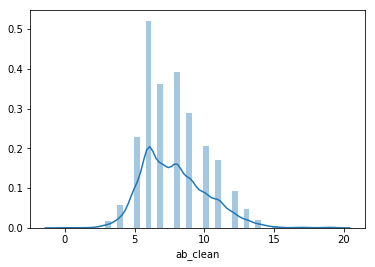

In [145]:
sns.distplot(y_1_len)

In [146]:
y_0_len_5.value_counts().head(10)

False    981
True     244
Name: ab_clean, dtype: int64

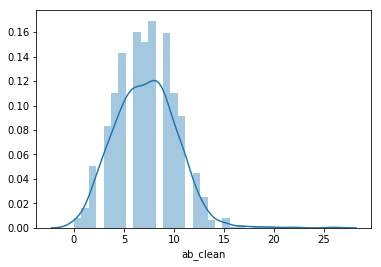

In [147]:
sns.distplot(y_0_len)

In [148]:
y_1_len_5.value_counts().head(10)

False    2864
True       94
Name: ab_clean, dtype: int64

***Features***

In [149]:
df_train_merge['num_words'] = df_train_merge['ab_clean'].apply(len) > 5
df_test_merge['num_words'] = df_test_merge['ab_clean'].apply(len) > 5
features.add('num_words')

## User Name

In [150]:
df_train_merge['user_name'] = df_train_merge['user_name'].fillna('')
df_test_merge['user_name'] = df_test_merge['user_name'].fillna('')
y_1_usr = [xx for x in df_train_merge[df_train_merge['Event ID'] >= 1]['user_name'].apply(lambda x:x.split(' ')) for xx in x if len(xx) > 0]
y_0_usr = [xx for x in df_train_merge[df_train_merge['Event ID'] == 0]['user_name'].apply(lambda x:x.split(' ')) for xx in x if len(xx) > 0]

In [151]:
pd.Series(y_0_usr).value_counts().head(10)

@EVKDailyMenu    43
the              20
Living           15
Food             14
Safely™          14
David            13
Chad             12
HandWashBot      12
News             10
of                8
dtype: int64

In [152]:
pd.Series(y_1_usr).value_counts().head(10)

News      228
The        41
Health     37
FOX        26
&          21
Food       21
Report     19
NBC        17
11         16
12         15
dtype: int64

In [153]:
df_train_merge['user_name_words'] = df_train_merge['user_name'].apply(lambda x:x.split(' '))
df_test_merge['user_name_words'] = df_test_merge['user_name'].apply(lambda x:x.split(' '))

***Feature***

In [154]:
user_name_words = ['News']

In [155]:
for temp in [df_train_merge, df_test_merge]:
    for col in user_name_words:
        temp['user_name_word_' + col] = temp['user_name_words'].apply(lambda x: col in x)
        features.add('user_name_word_' + col)

## Media

In [156]:
df_train_merge['medias'] = df_train_merge['medias'].fillna('')
df_test_merge['medias'] = df_test_merge['medias'].fillna('')

In [157]:
y_1_media = df_train_merge[df_train_merge['Event ID'] >= 1]['medias'].apply(lambda x: len(x) if x else 0)
y_0_media = df_train_merge[df_train_merge['Event ID'] == 0]['medias'].apply(lambda x: len(x) if x else 0)

In [158]:
pd.Series(y_0_media).value_counts().head(10)

0     1172
50      38
62      12
91       3
Name: medias, dtype: int64

In [159]:
pd.Series(y_1_media).value_counts().head(10)

0     2425
50     532
62       1
Name: medias, dtype: int64

In [160]:
df_train_merge['has_media'] = df_train_merge['medias'].apply(lambda x: True if len(x) > 0 else False)
df_test_merge['has_media'] = df_test_merge['medias'].apply(lambda x: True if len(x) > 0 else False)
features.add('has_media')

## Question Mark

In [161]:
df_train_merge['Abstract'] = df_train_merge['Abstract'].fillna('')
df_test_merge['Abstract'] = df_test_merge['Abstract'].fillna('')

In [162]:
df_train_merge['question_mark'] = df_train_merge['Abstract'].apply(lambda x: len([c for c in x if c == '?']))
df_test_merge['question_mark'] = df_test_merge['Abstract'].apply(lambda x: len([c for c in x if c == '?']))
features.add('question_mark')

# Run Binary Classification Model with Manual Feature

## New Manual Features

In [163]:
for feature in features:
    print(feature)
    display(pd.DataFrame(df_train_merge[feature].value_counts()).head(5))

user_name_word_News


,user_name_word_News
False,3945
True,238


neg_noun_me


,neg_noun_me
False,4126
True,57


neg_noun_I


,neg_noun_I
False,4023
True,160


num_words


,num_words
True,3435
False,748


hashtag_RECALL


,hashtag_RECALL
False,4131
True,52


hashtag_SmartNews


,hashtag_SmartNews
False,4162
True,21


word_allergy


,word_allergy
False,4140
True,43


nnp


,nnp
True,3384
False,799


hashtag_Recall


,hashtag_Recall
False,4134
True,49


neg_noun_i


,neg_noun_i
False,4108
True,75


has_media


,has_media
False,3597
True,586


neg_noun_You


,neg_noun_You
False,4156
True,27


question_mark


,question_mark
0,3759
1,181
2,111
4,53
3,23


mention_googlenews


,mention_googlenews
False,4167
True,16


word_alert


,word_alert
False,3810
True,373


neg_noun_they


,neg_noun_they
False,4143
True,40


word_outbreak


,word_outbreak
False,4027
True,156


word_recall


,word_recall
True,2922
False,1261


neg_noun_you


,neg_noun_you
False,4009
True,174


neg_noun_It


,neg_noun_It
False,4158
True,25


neg_noun_we


,neg_noun_we
False,4141
True,42


In [164]:
df_train_merge[features].head()

,user_name_word_News,neg_noun_me,neg_noun_I,num_words,hashtag_RECALL,hashtag_SmartNews,word_allergy,nnp,hashtag_Recall,neg_noun_i,...,neg_noun_You,question_mark,mention_googlenews,word_alert,neg_noun_they,word_outbreak,word_recall,neg_noun_you,neg_noun_It,neg_noun_we
0,False,False,False,True,False,True,False,False,False,False,...,False,0,False,False,False,False,True,False,False,False
1,False,False,False,True,False,False,False,True,False,False,...,False,0,False,False,False,False,True,False,False,False
2,False,False,False,True,False,False,False,True,False,False,...,False,0,False,False,False,False,True,False,False,False
3,False,False,False,True,False,False,False,True,False,False,...,False,0,False,False,False,False,True,False,False,False
4,False,False,False,True,False,False,False,False,False,False,...,False,0,False,False,False,False,True,False,False,False


## Quick Logistic Regression

In [165]:
features_ = list(features)

In [166]:
X_train = df_train_merge[features_]
y_train = df_train_merge['Is_Food']

In [167]:
param_test_lr =  {'C' :[10 ** x for x in list(range(-3,4,1))]}
param_test_lr['C']

[0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [168]:
gsearch_lr = GridSearchCV(estimator = LogisticRegression( 
        penalty='l2', 
        solver='liblinear',
        max_iter=1000,
        class_weight = 'balanced'
    ),                   
    param_grid = param_test_lr, 
        scoring = {'AUC': 'roc_auc'},
        cv = 5,
        n_jobs = 4, 
        refit = 'AUC')

In [169]:
gsearch_lr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc'}, verbose=0)

**Take a look at impact of penalty param**

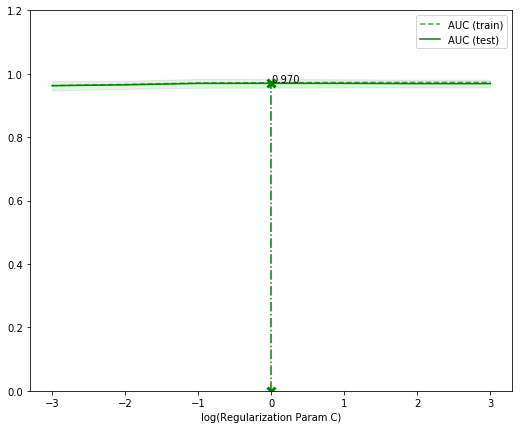

In [170]:
plot_auc(gsearch_lr)

**Refit the model with best C**

In [171]:
best_C = gsearch_lr.best_params_['C']
print('The best C is '+ str(best_C))

The best C is 1


In [172]:
best_AUC_lr = gsearch_lr.best_score_
print('The best AUC is '+ str(best_AUC_lr))

The best AUC is 0.9695744541036666


In [173]:
lr_ = LogisticRegression(penalty='l2', solver='liblinear', C=best_C, max_iter=1000,class_weight = 'balanced')
lr_ = lr_.fit(X = X_train, y = y_train)

**Investigate Coefficients**

Some of the words do not make sense because they are too event-specific

In [174]:
coef_df = pd.DataFrame({'variable':features_, 'coefficient':lr_.coef_[0]})
coef_df.sort_values(by = 'coefficient')

,variable,coefficient
1,neg_noun_me,-2.062773
20,neg_noun_we,-1.748697
19,neg_noun_It,-1.720656
16,word_outbreak,-1.498803
18,neg_noun_you,-1.231425
11,neg_noun_You,-1.067861
2,neg_noun_I,-0.920462
9,neg_noun_i,-0.249350
12,question_mark,-0.162100
15,neg_noun_they,-0.144311


**Apply to test set**

In [178]:
subset = ~df_test_merge['zero_length']
X_test = df_test_merge.loc[subset, features_]

In [179]:
print('There is a total of', len(df_test_merge), 'in test set')
print('There is a total of', len(df_test_merge[subset]), 'in test set with non-zero length')
pred_probs = [x[1] for x in lr_.predict_proba(X_test)]
preds = lr_.predict(X_test)
print('There is a total of', sum(preds), 'predicted to be food-related events')

There is a total of 22840 in test set
There is a total of 21156 in test set with non-zero length
There is a total of 2289 predicted to be food-related events


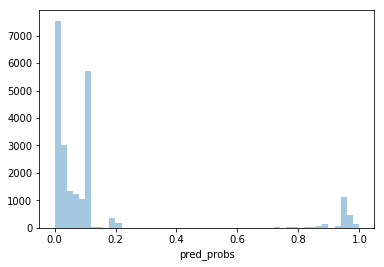

In [184]:
df_test_merge.loc[subset, 'preds'] = preds
df_test_merge.loc[subset, 'pred_probs'] = pred_probs
df_test_merge.loc[~subset, 'preds'] = False
df_test_merge.loc[~subset, 'pred_probs'] = 0
sns.distplot(df_test_merge['pred_probs'], kde = False)

In [185]:
X = df_test_merge
X['has_recall'] = X['ab_clean'].apply(lambda x: 'recall' in x)

In [186]:
X.groupby(['preds', 'has_recall'])['Date'].agg(len)

preds  has_recall
False  False         20517
       True             34
True   False            29
       True           2260
Name: Date, dtype: int64

# Export results

In [214]:
outputs = {'df_train_merge': df_train_merge,
           'df_test_merge': df_test_merge,}
with open('./processed_data/outputs.pickle', 'wb') as handle:
    pickle.dump(outputs, handle)

In [217]:
with open('./outputs.pickle', 'rb') as handle:
    outputs = pickle.load(handle)
df_train_merge = outputs['df_train_merge']
df_test_merge = outputs['df_test_merge']

In [218]:
df_train_merge.head(1)

,Date,Time,Trainig/Test,Event ID,Title,Link,Abstract,Is_Food,tweet_id,external_url,...,word_outbreak,hashtag_RECALL,hashtag_Recall,hashtag_SmartNews,mention_googlenews,num_words,user_name_words,user_name_word_News,has_media,question_mark
0,2019-02-05,18:45:44,Training,1.0,New dog food recall and latest warning on grain-free foods #SmartNews,https://twitter.com/tweet/status/1092857075753861125,New dog food recall and latest warning on grain-free foods #SmartNews https://t.co/nS49e7r63l,True,1092857075753861125,https://t.co/nS49e7r63l,...,False,False,False,True,False,True,"[Sondra, Gail, Adam]",False,False,0


In [219]:
df_test_merge.head(1)

,Date,Time,Training/Test,Title,Link,Abstract,tweet_id,external_url,tweet_found,user_name,...,hashtag_SmartNews,mention_googlenews,num_words,user_name_words,user_name_word_News,has_media,question_mark,preds,pred_probs,has_recall
0,2019-03-07,23:59:31,Test,@pccs_heron Salmonella,https://twitter.com/tweet/status/1103807421800202242,@pccs_heron Salmonella,1103807421800202242,None,True,Tabb_Science,...,False,False,True,[Tabb_Science],False,False,0,False,0.115345,False
